# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import pandas as pd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors

sys.path.insert(0, '../')
from PlottingFunctions import *

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]
central_lsoas.reset_index(inplace=True)

## Get gentrification scores for each listing

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
# score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_new_02.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[["LSOA11NM", 'gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

LSOA11NM gentrification_prediction  \
0  Bolton 001A                  Emerging   
1  Bolton 001A               Established   
2  Bolton 001B                  Emerging   
3  Bolton 001C               Gentrifying   
4  Bolton 002A               Established   

                                         explanation  \
0  The neighborhood is described as a quiet hamle...   
1  The area is described as a comfortable base fo...   
2  The neighborhood is described as quiet and saf...   
3  The village of Egerton is described as quaint,...   
4  The area of Bradshaw is described as desirable...   

   gentrification_prediction_code  longitude  latitude  
0                               2  -2.450007  53.61350  
1                               4  -2.439220  53.61273  
2                               2  -2.446700  53.63582  
3                               3  -2.439940  53.62988  
4                               4  -2.395160  53.60852

### Convert to geodataframe of scores per listing, reproject to BNG

In [12]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf = score_per_listing_gdf.set_crs(epsg=4326, allow_override=True)
score_per_listing_gdf = score_per_listing_gdf.to_crs(epsg=27700)

# # Keep only those in central LSOAs
score_per_listing_gdf = gpd.sjoin(
    score_per_listing_gdf,
    central_lsoas[["LSOA11NM", "geometry"]],
    how="inner",          # keep only matches
    predicate="within")

score_per_listing_gdf.head()

LSOA11NM_left gentrification_prediction  \
406     Bury 023C               Established   
407     Bury 023C               Gentrifying   
408     Bury 023C               Gentrifying   
409     Bury 023C               Established   
410     Bury 023C               Established   

                                           explanation  \
406  The description of Heaton Park as a major muni...   
407  The newly redecorated apartment, proximity to ...   
408  The completely renovated home, description of ...   
409  The description of the neighborhood as "friend...   
410  The focus on the convenience for attending the...   

     gentrification_prediction_code  longitude   latitude  \
406                               4  -2.273020  53.531710   
407                               3  -2.269601  53.532356   
408                               3  -2.269350  53.532790   
409                               4  -2.271682  53.532365   
410                               4  -2.268370  53.534400   

                          geometry  index_right LSOA11NM_right  
406  POINT (382000.352 403929.574)            0      Bury 023C  
407   POINT (382227.252 404000.57)            0      Bury 023C  
408  POINT (382244.071 404048.802)            0      Bury 023C  
409  POINT (382089.318 404002.156)            0      Bury 023C  
410  POINT (382309.704 404227.677)            0      Bury 023C

### Find which LSOA each listing is within

In [13]:
del score_per_listing_gdf['LSOA11NM_left']
score_per_listing_gdf.rename(columns = {'LSOA11NM_right':'LSOA11NM'}, inplace=True)
score_per_listing_gdf.reset_index(inplace=True, drop=True)
score_per_listing_gdf.head()

# get rid of LSOAs with no values
score_per_listing_gdf = score_per_listing_gdf[~score_per_listing_gdf['gentrification_prediction_code'].isna()]
score_per_listing_gdf

gentrification_prediction  \
0                  Established   
1                  Gentrifying   
2                  Gentrifying   
3                  Established   
4                  Established   
...                        ...   
3983                  Emerging   
3984                  Emerging   
3985               Gentrifying   
3986               Gentrifying   
3987                  Emerging   

                                            explanation  \
0     The description of Heaton Park as a major muni...   
1     The newly redecorated apartment, proximity to ...   
2     The completely renovated home, description of ...   
3     The description of the neighborhood as "friend...   
4     The focus on the convenience for attending the...   
...                                                 ...   
3983  The description of Stretford as a "lovely comm...   
3984  The mention of good local infrastructure, prox...   
3985  The description of a "fantastic location" with...   
3986  The emphasis on Stretford being a "thriving ar...   
3987  The description of the area as perfect for pro...   

      gentrification_prediction_code  longitude   latitude  \
0                                  4  -2.273020  53.531710   
1                                  3  -2.269601  53.532356   
2                                  3  -2.269350  53.532790   
3                                  4  -2.271682  53.532365   
4                                  4  -2.268370  53.534400   
...                              ...        ...        ...   
3983                               2  -2.307347  53.450096   
3984                               2  -2.316190  53.452260   
3985                               3  -2.310740  53.449860   
3986                               3  -2.317030  53.451970   
3987                               2  -2.313900  53.452480   

                           geometry  index_right       LSOA11NM  
0     POINT (382000.352 403929.574)            0      Bury 023C  
1      POINT (382227.252 404000.57)            0      Bury 023C  
2     POINT (382244.071 404048.802)            0      Bury 023C  
3     POINT (382089.318 404002.156)            0      Bury 023C  
4     POINT (382309.704 404227.677)            0      Bury 023C  
...                             ...          ...            ...  
3983  POINT (379685.792 394858.979)          274  Trafford 011D  
3984  POINT (379099.601 395102.303)          275  Trafford 011E  
3985  POINT (379460.364 394833.704)          275  Trafford 011E  
3986  POINT (379043.674 395070.288)          275  Trafford 011E  
3987  POINT (379251.784 395126.107)          275  Trafford 011E  

[3988 rows x 8 columns]

### Check this spatially

## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [14]:
per_LSOA_summary = (
    score_per_listing_gdf
    .groupby("LSOA11NM")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_LSOA_summary = central_lsoas[['LSOA11NM', 'geometry']].merge(per_LSOA_summary, on='LSOA11NM')
per_LSOA_summary = per_LSOA_summary[per_LSOA_summary['dominant_class'].notnull()]
per_LSOA_summary['dominant_class'] = per_LSOA_summary['dominant_class'].astype(int)

In [15]:
my_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), my_colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)
per_LSOA_summary['color']= per_LSOA_summary['dominant_class'].map(color_map)

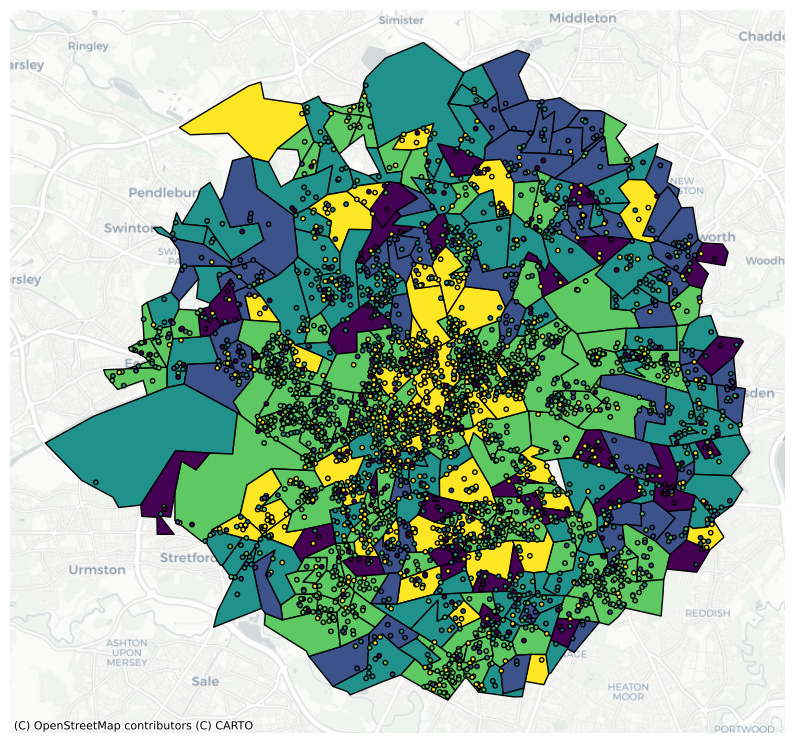

In [33]:
fig,ax=plt.subplots(figsize=(10,10))

# Plot using the 'color' column directly
per_LSOA_summary_wm = per_LSOA_summary.to_crs(epsg=3857)
per_LSOA_summary_wm.plot(color=per_LSOA_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

score_per_listing_gdf_wm = score_per_listing_gdf.to_crs(epsg=3857)
score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=10);

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_gdf_wm.crs)

ax.axis("off");
fig.savefig("../Figures/Manchester_modal_with_listings.png", bbox_inches='tight')

## Plot

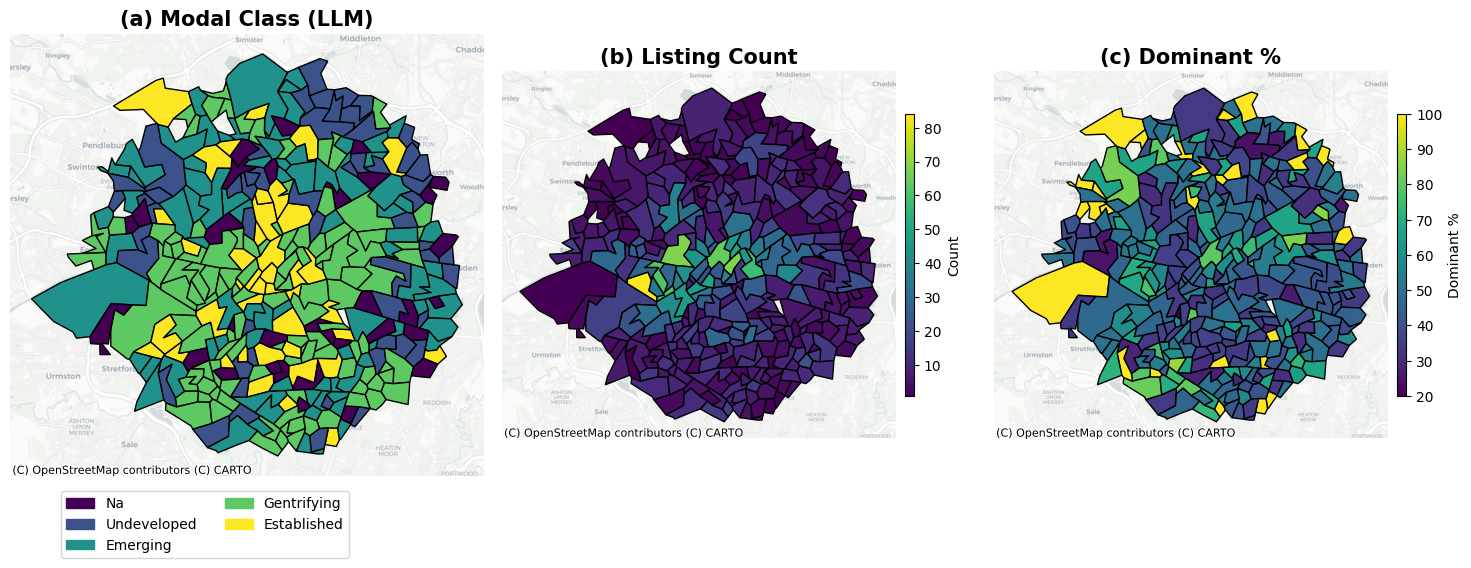

In [41]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # wider but flatter

# Ensure CRS is web mercator for basemap
per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)

# Common legend keyword settings
legend_opts = {
    "shrink": 0.6,
    "orientation": "vertical",
    "pad": 0.02,
    "aspect": 30}

# Second plot: dominant class
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0], edgecolor='black', legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.14, -0.12),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

# First plot: count
per_LSOA_summary.plot(
    "count", alpha=1, ax=axs[1], legend=True,edgecolor='black',
    legend_kwds={"label": "Count", **legend_opts})
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)

# Third plot: dominant percent
per_LSOA_summary.plot(
    "dominant_pct", alpha=1, ax=axs[2], legend=True,edgecolor='black',
    legend_kwds={"label": "Dominant %", **legend_opts})
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)

# Tidy up
for ax in axs:
    ax.axis('off')

plt.tight_layout()
fig.savefig("../Figures/Manchester_LLM-scores.png", bbox_inches = 'tight')
plt.show()

### Gentrification index spatial plot

In [18]:
g_index = pd.read_csv("../../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
g_index_gdf = central_lsoas[['LSOA11NM', 'geometry']].merge(g_index, on='LSOA11NM')

In [ ]:
# g_index_gdf = g_index_gdf.to_crs(epsg=3857)
# g_index_gdf.head()

In [ ]:
# per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)
# per_LSOA_summary.head()

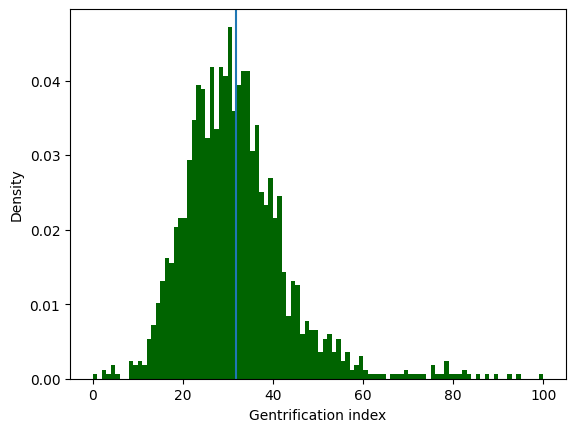

In [31]:
plt.hist(g_index['gi_n'], bins=100, color='darkgreen', density=True);
plt.axvline(np.mean(g_index['gi_n']))
plt.ylabel('Density')
plt.xlabel('Gentrification index');
plt.savefig("../Figures/Manchester_GI_histogram.png", bbox_inches = 'tight')
np.mean(g_index['gi_n']);

In [ ]:
# fig, axs = plt.subplots(ncols = 2, figsize=(10, 10), sharey=True, sharex=True)

# # Plot the data
# g_index_gdf.plot(column='gi_n',cmap='viridis',vmin=20,vmax=60,ax=axs[0],legend=False)

# # Create divider and color axis
# divider = make_axes_locatable(axs[0])
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create ScalarMappable for colorbar
# norm = colors.Normalize(vmin=20, vmax=60)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm._A = []  # dummy array

# # Add colorbar
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label("GI Index")

# ########### axis2
# g_index_gdf.plot('gi_n', ax=axs[1])

# # Create divider and color axis
# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create ScalarMappable for colorbar
# norm = colors.Normalize(vmin=0, vmax=100)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm._A = []  # dummy array
# # Add colorbar
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label("GI Index")

# axs[0].axis("off")
# axs[1].axis("off");

/tmp/ipykernel_23148/1142095155.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


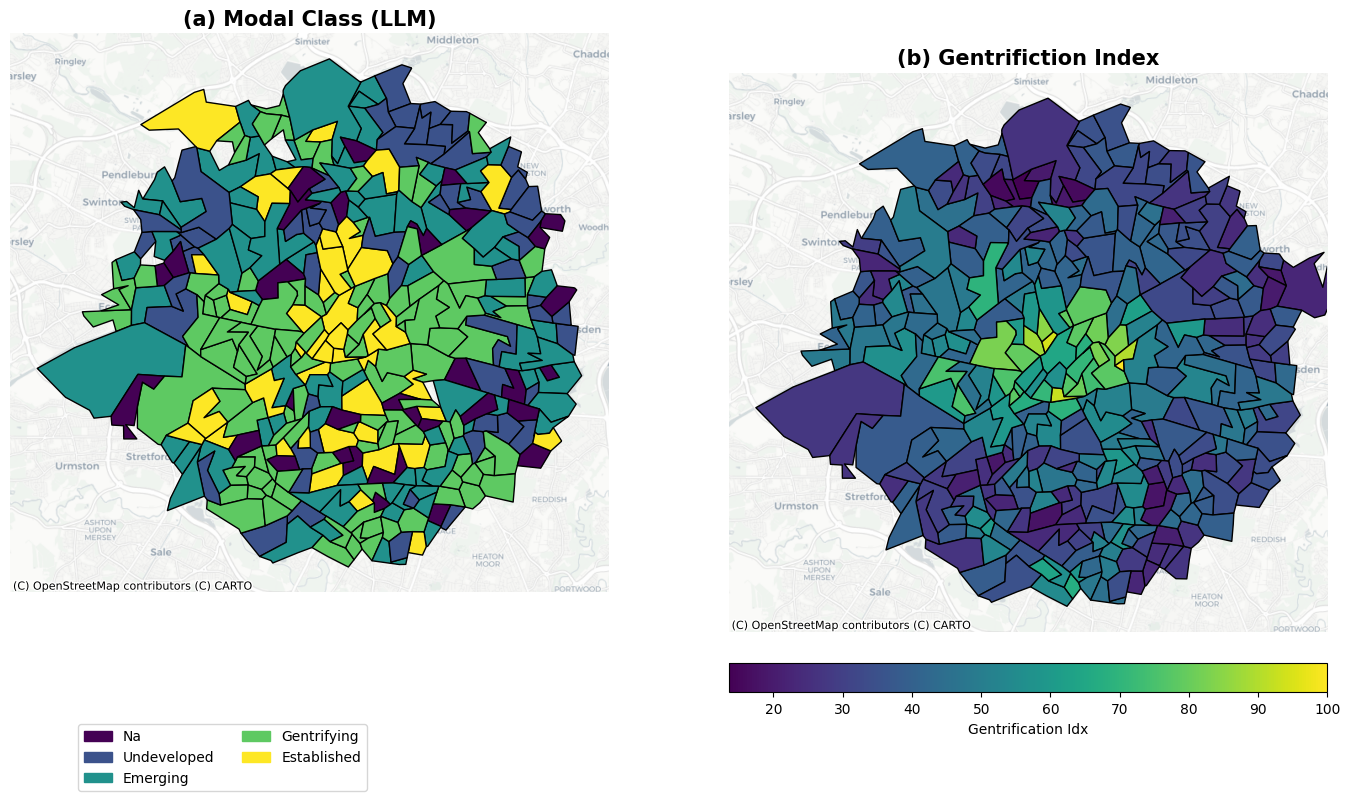

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(17, 10), sharey=True, sharex=True)

# (a) LLM map
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0],  edgecolor='black', legend=False)
    # legend_kwds={"label": "ModalClass", **legend_opts})
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]

# (b) GI map
g_index_gdf = g_index_gdf.to_crs(epsg=3857)
g_index_gdf.plot(
    'gi_n',
    ax=axs[1],
    legend=False,
    edgecolor='black')

ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
# Create colorbar manually
norm = mpl.colors.Normalize(vmin=g_index_gdf['gi_n'].min(), vmax=g_index_gdf['gi_n'].max())
cmap = plt.cm.get_cmap('viridis')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs[1],
    orientation='horizontal',
    fraction=0.046,  # size of colorbar relative to plot
    pad=0.04         # gap between plot and colorbar
)
cbar.set_label("Gentrification Idx")
axs[1].axis("off")
axs[1].set_title("(b) Gentrification Index", fontweight='bold', fontsize=15)

# --- Create legends & colorbar at the bottom ---
# 1. LLM legend
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.25, 0.01),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

In [21]:
bins = [0, 15, 30, 45, 60, float('inf')]
labels = [1, 2, 3, 4, 5]

g_index_gdf["gi_n_cat"] = pd.cut(
    g_index_gdf["gi_n"],
    bins=bins,
    labels=labels,
    right=False  # include the left edge, exclude the right edge
).astype(int)

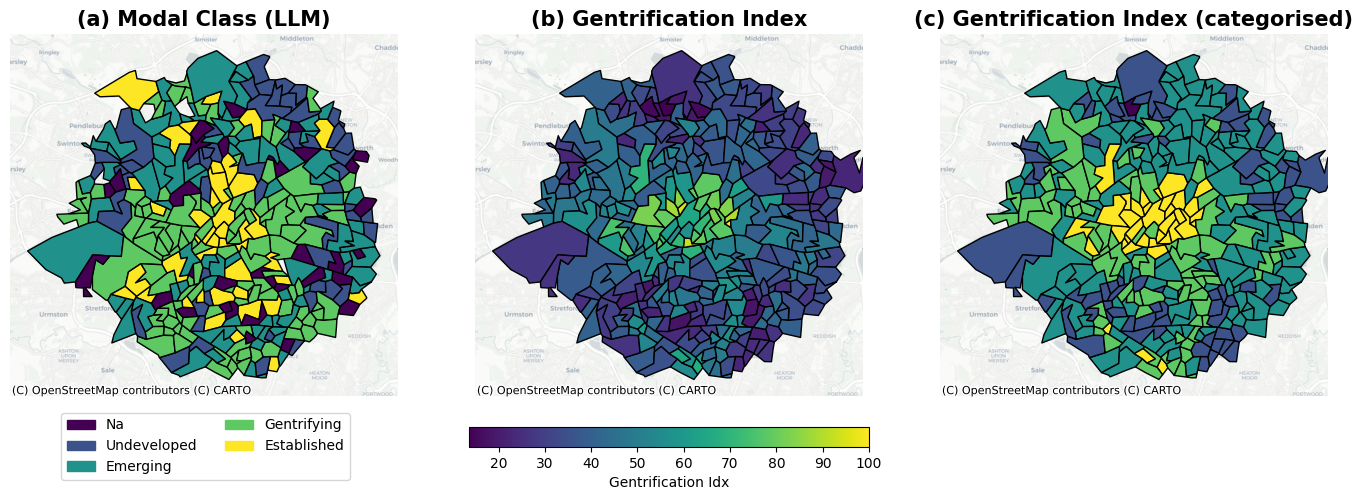

In [22]:
# Make sure both datasets are in Web Mercator (EPSG:3857)
per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)
g_index_gdf = g_index_gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(ncols=3, figsize=(17, 10), sharey=True, sharex=True)

########################### (a) LLM map
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0], edgecolor='black', legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.24, 0.07),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

###################### (b) GI map
g_index_gdf.plot(
    'gi_n', ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) Gentrification Index", fontweight='bold', fontsize=15)
axs[1].axis("off");#

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs,
    orientation='horizontal',
    fraction=0.026,  # size of colorbar relative to plot
    pad=0.04         # gap between plot and colorbar
)
cbar.set_label("Gentrification Idx")
axs[1].axis("off")
axs[1].set_title("(b) Gentrification Index", fontweight='bold', fontsize=15)

###################### (b) GI map
g_index_gdf.plot(
    "gi_n_cat", alpha=1, ax=axs[2], edgecolor='black', legend=False)
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Gentrification Index (categorised)", fontweight='bold', fontsize=15)
axs[2].axis("off")

fig.savefig("../Figures/Manchester_GI-scores.png", bbox_inches = 'tight')